In [1]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, text, inspect, func

# data
import pandas as pd
import numpy as np

# viz
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
SQL_USERNAME = ####  GRADER NEEDS TO PROVIDE THEIR OWN POSTGRES USER NAME  ###
SQL_PASSWORD = ####  GRADER NEEDS TO PROVIDE THEIR OWN POSTGRES PW  ###
SQL_IP = "localhost"
PORT = 5432
DATABASE = "project 2"

In [6]:
connection_string = f"postgresql+psycopg2://{SQL_USERNAME}:{SQL_PASSWORD}@{SQL_IP}:{PORT}/{DATABASE}"
engine = create_engine(connection_string)

In [7]:
# INSPECT

# Create the inspector and connect it to the engine
inspector_project_2 = inspect(engine)

# Collect the names of tables within the database
tables = inspector_project_2.get_table_names()

# print metadata for each table
for table in tables:
    print(table)
    print("-----------")
    
    # get columns
    columns = inspector_project_2.get_columns(table)
    for column in columns:
        print(column["name"], column["type"])

    print()

category
-----------
category_id TEXT
category TEXT

subcategory
-----------
subcategory_id TEXT
subcategory TEXT

contacts
-----------
contact_id BIGINT
first_name TEXT
last_name TEXT
email TEXT

campaign
-----------
cf_id BIGINT
contact_id BIGINT
company_name TEXT
description TEXT
goal DOUBLE PRECISION
pledged DOUBLE PRECISION
outcome TEXT
backers_count BIGINT
country TEXT
currency TEXT
launched_date TEXT
end_date TEXT
category_id TEXT
subcategory_id TEXT



In [8]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

# Print all of the classes mapped to the Base
print(list(Base.classes))

[]


In [45]:
# List the contact_id, outcome, category_id, and category to view the different outcomes of each category once the campaign and category tables are joined.
query = """
    SELECT c.contact_id, c.outcome, c.category_id, cat.category
    FROM campaign c
    JOIN category cat ON c.category_id = cat.category_id;
"""

df = pd.read_sql(text(query), con=engine)
df.head()

,contact_id,outcome,category_id,category
0,4532,successful,cat1,food
1,3274,successful,cat1,food
2,5565,failed,cat1,food
3,4404,failed,cat1,food
4,3307,successful,cat1,food


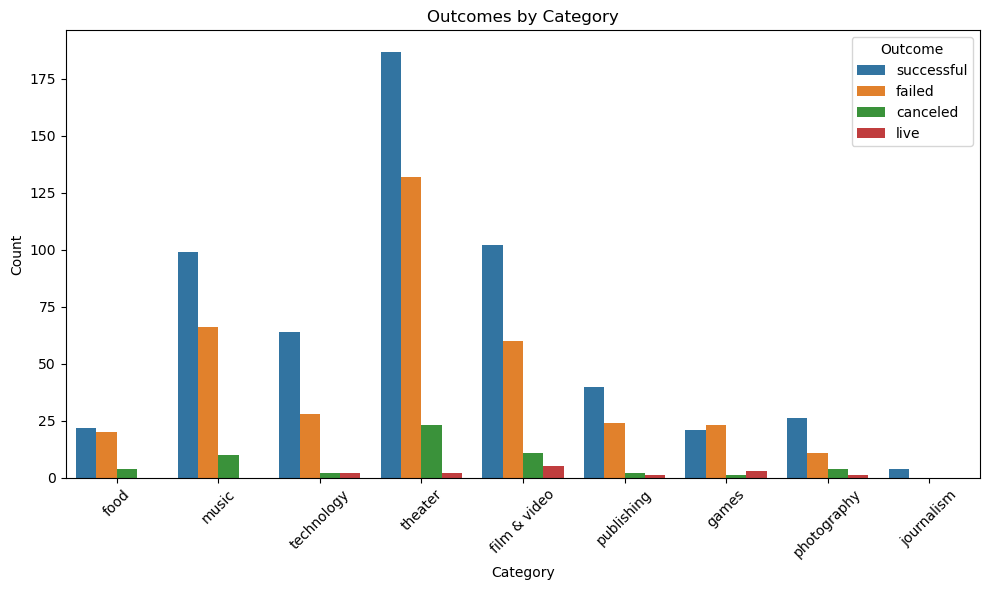

In [46]:
# Create a bar plot of outcomes by category
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='category', hue='outcome')
plt.title('Outcomes by Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.legend(title='Outcome')
plt.xticks(rotation=45) 
plt.tight_layout()

# Show the plot
plt.show()

In [47]:
# Query campaign table to find all the successful campaigns and group them by country.  I did exclude the US, due to the fact that it is the outlier compared to the rest of the countries.
query = """
        SELECT
            country,
            outcome,
            category_id
        FROM
            campaign
        WHERE
            outcome = 'successful'
            AND country != 'US';
        """
df = pd.read_sql(text(query), con=engine)
df.head()

,country,outcome,category_id
0,AU,successful,cat3
1,DK,successful,cat4
2,DK,successful,cat4
3,GB,successful,cat5
4,CH,successful,cat5


[Text(0, 0, 'AU'),
 Text(1, 0, 'CA'),
 Text(2, 0, 'CH'),
 Text(3, 0, 'DK'),
 Text(4, 0, 'GB'),
 Text(5, 0, 'IT')]

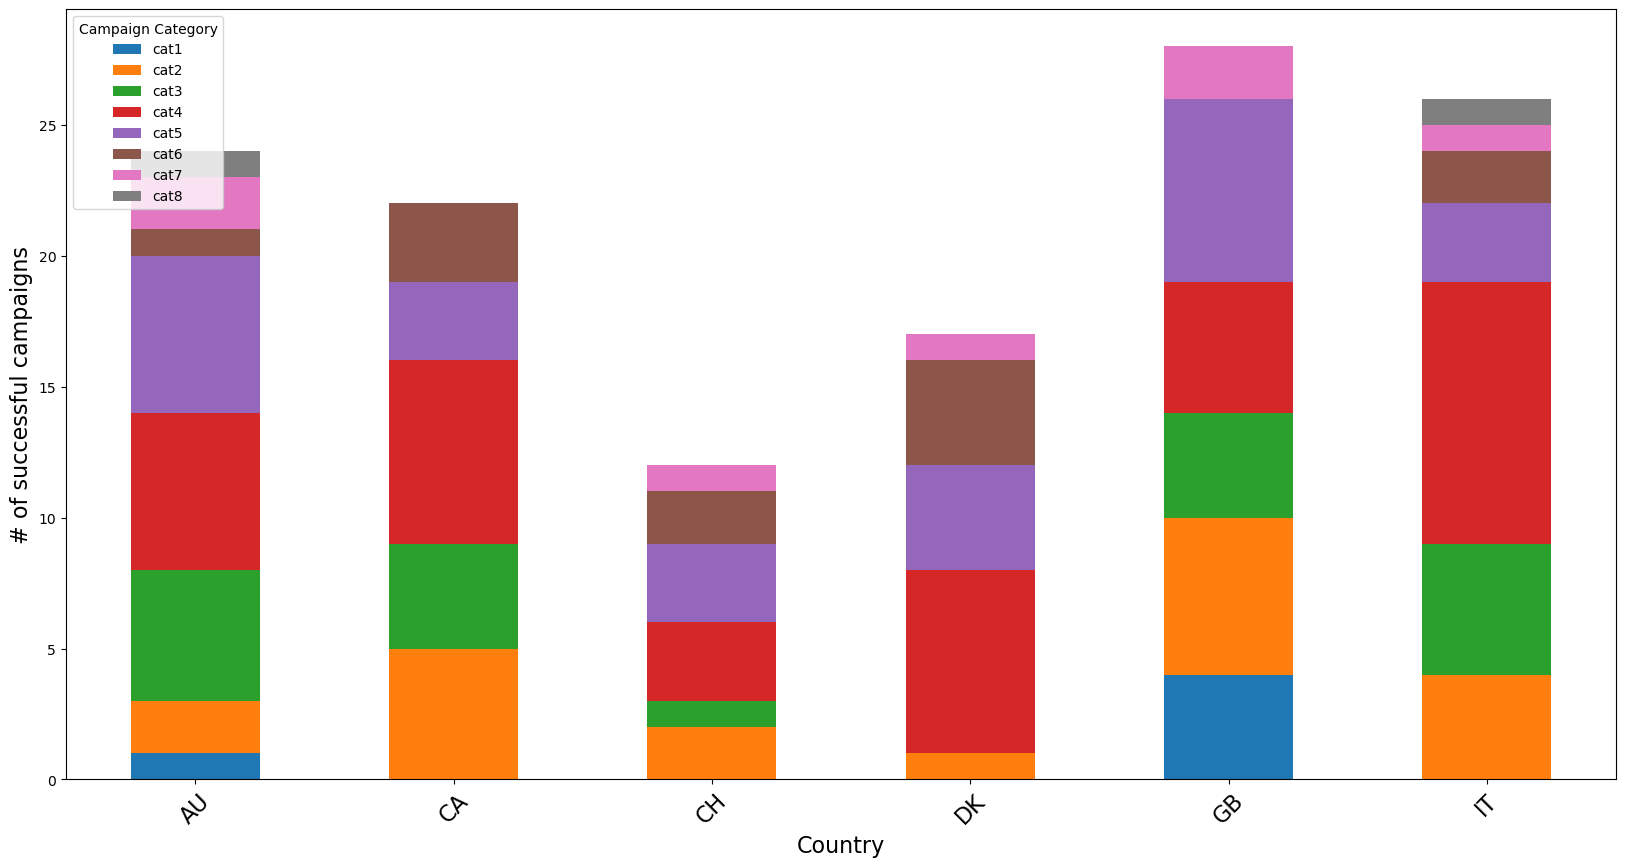

In [48]:
# Barchart that resulted was congested, I used the expert to help me clean it up and to stack the categories of campaign on top of each other.
country_df = df.groupby(['country', 'category_id']).size().unstack(fill_value=0)
country_df = country_df.reindex(sorted(country_df.index))
ax = country_df.plot(kind='bar', stacked=True, figsize=(20, 10))
ax.legend(title = 'Campaign Category', loc='upper left')
ax.set_xlabel('Country', fontsize = 16)
ax.set_ylabel('# of successful campaigns', fontsize = 16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=16)

In [10]:
query_succesful_subcategory ="""
       SELECT COUNT(c.outcome)as "Successful campaigns", s.subcategory
        FROM "campaign" c JOIN "subcategory" s ON c.subcategory_id = s.subcategory_id
        WHERE c.outcome = 'successful'
        GROUP BY s.subcategory
        ORDER BY "Successful campaigns" asc;
        """
df_subcategory = pd.read_sql(text(query_succesful_subcategory), con=engine)
df_subcategory

,Successful campaigns,subcategory
0,3,world music
1,4,audio
2,4,radio & podcasts
3,4,metal
4,4,mobile games
5,5,science fiction
6,9,fiction
7,9,shorts
8,10,electric music
9,10,jazz


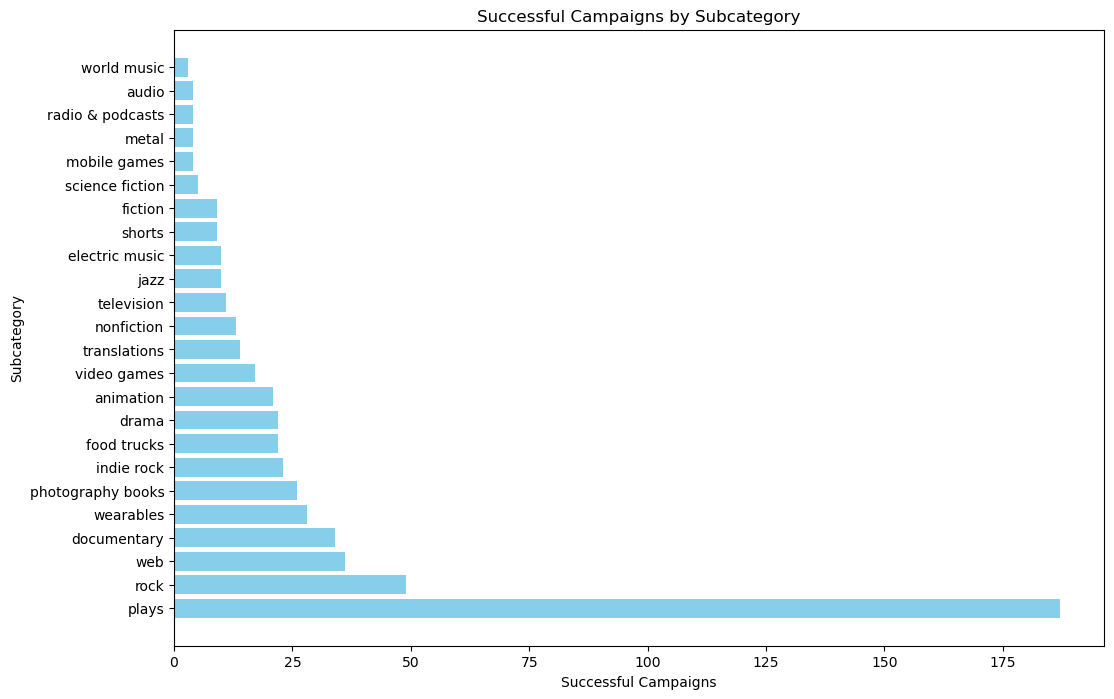

In [11]:
#Visualization
plt.figure(figsize=(12, 8))
plt.barh(df_subcategory['subcategory'], df_subcategory['Successful campaigns'], color='skyblue')
plt.xlabel('Successful Campaigns')
plt.ylabel('Subcategory')
plt.title('Successful Campaigns by Subcategory')
plt.gca().invert_yaxis()  # Invert the y-axis to display the categories from top to bottom
plt.savefig("Successful Campaings by Subcategory.png")
plt.show()